# Pauli error estimation via population recovery

This is an implementation of the algorithm in S. T. Flammia and R. O'Donnell, "Pauli error estimation via population recovery", *Quantum* **5**, 549 (2021); arXiv:2105.02885. 

We consider an example with $n=5$ qubits and $k=25$ nonzero Pauli error probabilities sampled at random. With $m=10^6$ samples, we don't expect to be able to reconstruct error rates with probabilities less than about $10^{-3}$. 

Pauli channels are stored as a dictionary `P => p`, where the values `p` are the probabilities as `Float64`, and the Pauli errors `P` are the keys stored as `Vector{Int8}` with elements in `(0,1,2,3)`.

In [1]:
using PauliPopRec

# Prepare m random n-qubit probe states
n = 5 # number of qubits
m = 10^6 # number of measurements
A = rand(Int8.(1:3),m,n)

# Define a random Pauli channel on n qubits
k = 25 # size of channel support
δ = 0.2 # probability of some nontrivial error occurring
P = randpaulichannel(n,k,δ)

# Simulate sending the states A through the channel P and measuring to get the results R
R = probepaulichannel(P,A)

P

Dict{Vector{Int8}, Float64} with 25 entries:
  [1, 2, 0, 0, 1] => 0.0171853
  [1, 1, 2, 2, 2] => 0.00708816
  [2, 0, 1, 0, 0] => 0.00421345
  [3, 3, 0, 3, 0] => 0.0165246
  [2, 2, 1, 1, 3] => 0.00594726
  [1, 2, 1, 3, 0] => 0.00313541
  [2, 2, 2, 3, 2] => 0.0013377
  [1, 3, 3, 1, 2] => 0.00103265
  [3, 3, 0, 2, 3] => 0.0163807
  [3, 2, 3, 0, 2] => 0.0045445
  [1, 0, 0, 2, 0] => 0.010919
  [2, 3, 2, 1, 2] => 0.00917191
  [0, 2, 0, 0, 0] => 0.0147674
  [0, 1, 0, 0, 0] => 0.0480647
  [3, 3, 3, 1, 1] => 0.00101391
  [3, 2, 0, 3, 3] => 0.00049051
  [2, 3, 3, 3, 2] => 0.00607135
  [3, 3, 0, 3, 2] => 0.00283667
  [3, 2, 2, 3, 3] => 0.0036709
  [1, 2, 0, 1, 2] => 0.0108487
  [3, 2, 2, 1, 2] => 0.00278491
  [0, 0, 0, 0, 0] => 0.8
  [0, 0, 1, 3, 0] => 0.00340718
  [3, 3, 3, 2, 0] => 0.000998895
  [1, 0, 1, 3, 2] => 0.0075642

We can run the algorithm with a specific choice of threshold value for pruning. Here we just choose $1/\sqrt{m}$, even though the rigorous theorem requires using some log factors. We get a pretty accurate reconstruction, as quantified by the TVD.

In [2]:
ϵ = 1/sqrt(m) # pick a simple choice for the thresholding value
@time Q = pauli_poprec(A,R,ϵ)

  6.753876 seconds (3.29 M allocations: 6.775 GiB, 11.63% gc time, 15.02% compilation time)


Dict{Vector{Int8}, Float64} with 22 entries:
  [1, 1, 2, 2, 2] => 0.00743269
  [1, 2, 0, 0, 1] => 0.017064
  [2, 0, 1, 0, 0] => 0.00387862
  [3, 3, 0, 3, 0] => 0.0166945
  [1, 2, 1, 3, 0] => 0.00328359
  [2, 2, 2, 3, 2] => 0.00128137
  [2, 2, 1, 1, 3] => 0.00577941
  [3, 3, 0, 2, 3] => 0.0166225
  [3, 2, 3, 0, 2] => 0.00447806
  [1, 0, 0, 2, 0] => 0.0108779
  [2, 3, 2, 1, 2] => 0.00909047
  [0, 2, 0, 0, 0] => 0.0147458
  [0, 1, 0, 0, 0] => 0.0480478
  [2, 3, 3, 3, 2] => 0.00605119
  [3, 3, 3, 1, 1] => 0.00120262
  [3, 3, 0, 3, 2] => 0.00260072
  [1, 2, 0, 1, 2] => 0.0111207
  [3, 2, 2, 3, 3] => 0.00359006
  [3, 2, 2, 1, 2] => 0.00237769
  [0, 0, 0, 0, 0] => 0.800447
  [0, 0, 1, 3, 0] => 0.00366478
  [1, 0, 1, 3, 2] => 0.00751416

In [4]:
pauli_tvd(P,Q)

0.003146695649447614

The error bars are fairly tight as well.

In [5]:
σ = pauli_stderr(Q,A,R)

22-element Vector{Float64}:
 0.00016472697898038734
 0.00026020335518068573
 0.00026643539596810247
 0.0002640111230050797
 0.00019312837890984115
 0.0001599766245092694
 0.0001588822028139537
 0.00022037876836274826
 0.0001898716995878623
 0.00028430371879960216
 0.00017291790896100385
 0.0004199647505873912
 0.0004130340177218331
 0.00016775852001727338
 0.00014951105817101248
 0.0002126823786567427
 0.00021494757681323536
 0.00016008466500252622
 0.0001649771965519106
 0.00045180137727268124
 0.0002675966118066497
 0.00018240706491183512

What about the estimates that we threw away with our choice of threshold? We can see what those estimates look like by computing all the probability estimates for every Pauli string, even the ones less than $\delta$ but that are still positive. What does the TVD look like now? 

In [6]:
@time S = pauli_totalrecall(A,R)
pauli_tvd(P,S)

 32.155058 seconds (2.38 M allocations: 34.428 GiB, 8.25% gc time, 1.96% compilation time)


0.041129833862201474

We can do a scatter plot to compare the complete list of nonnegative estimates to the thresholded values and the "true" values. 

In [7]:
using Plots

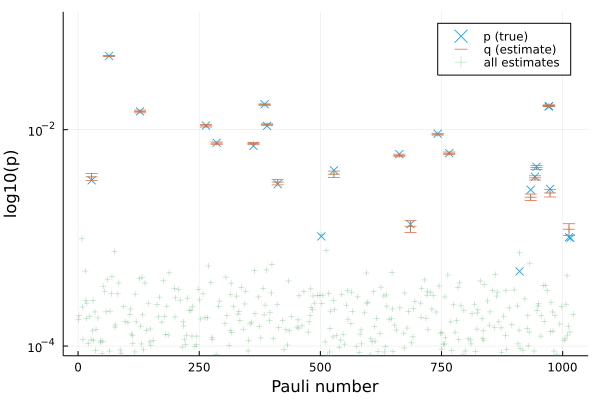

In [8]:
# convert the dictionary key quaternary digits to plotable numbers
keys2num(P) = hcat(collect(keys(P))...)' * (4 .^((length.(collect(keys(P)))[1]-1):-1:0))
vals2num(P) = collect(values(P))

scatter(keys2num(P), vals2num(P), 
    yaxis = ("log10(p)",:log10, [1e-4,1e-1]),
    xaxis = "Pauli number",
    label = "p (true)", markershape = :x, markersize = 4)
scatter!(keys2num(Q), vals2num(Q),
    label = "q (estimate)", markershape = :hline, markersize = 6,
    markerstrokecolor = :auto, yerror = σ)
scatter!(keys2num(S), vals2num(S),
    label = "all estimates", markershape = :+, markersize = 3, markeralpha = .3)